In [1]:
# imports
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d, convolve1d
import time
import lap
from functools import cmp_to_key

# notebook settings
np.set_printoptions(edgeitems=11,infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=True, threshold=20, formatter=None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
matplotlib.rcParams.update({'font.size': 18})

### Utility for plotting and image generation

In [2]:
''' Plots any given number of images'''
def plot_grid(*images, figsize=6, fignumber="Filter", titles=None, occurences=False):
    num_plots = len(images)
    
    plt.close(fignumber)
    fig = plt.figure(figsize=(figsize* int(min(num_plots, 5)), figsize*int(max(num_plots//5, 1))), num=fignumber)

    for i, grid in enumerate(images):
        
        size = grid.shape
        
        if size[-1] == 1:
            if occurences:
                cmap=None
            else:
                cmap="gray"
        else:
            cmap=None
        
        if len(size) == 3:
            ax = fig.add_subplot(((num_plots - 1) // 5) + 1, min(int(num_plots % 5) + (int(num_plots // 5) * 5), 5), i+1)
            img = grid.reshape(*size)
            ax.imshow(np.squeeze(img), cmap=cmap, vmin=0)
            ax.set_xticks([])
            ax.set_yticks([])
             
        if titles is not None:
            ax.set_title(titles[i])
    
    plt.show()

In [3]:
''' Generates a random uniform RGB Image'''
def generate_random_colors(nx=32, ny=32):
    np.random.seed(3)
    return np.random.uniform(0, 255, size=(nx, ny, 3)).astype(int)

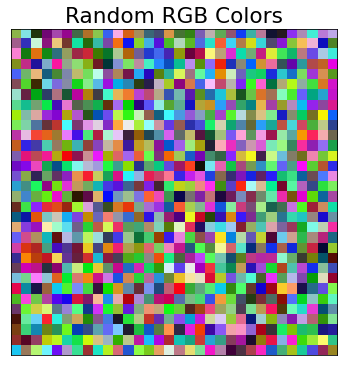

In [4]:
X = generate_random_colors(32, 32)
plot_grid(X, titles=["Random RGB Colors"])

## Sorting with FLAS and LAS

In [5]:
''' Calculates the squared L2 (eucldean) distance using numpy. '''
def squared_l2_distance(q, p):
    
    ps = np.sum(p*p, axis=-1, keepdims=True)    
    qs = np.sum(q*q, axis=-1, keepdims=True)
    distance = ps - 2*np.matmul(p, q.T) + qs.T
    return np.clip(distance, 0, np.inf)

In [6]:
''' Applies a low pass filter to the current image'''
def low_pass_filter(image, filter_size_x, filter_size_y, wrap=False):
    
    mode = "wrap" if wrap else "reflect" # nearest
    
    im2 = uniform_filter1d(image, filter_size_y, axis=0, mode=mode)  
    im2 = uniform_filter1d(im2, filter_size_x, axis=1, mode=mode)  
    return im2

In [7]:
''' Utility function that takes a position and returns 
a desired number of positions in the given radius'''
def get_positions_in_radius(pos, indices, r, nc, wrap):
    if wrap:
        return get_positions_in_radius_wrapped(pos, indices, r, nc)
    else:
        return get_positions_in_radius_non_wrapped(pos, indices, r, nc)

In [8]:
''' Utility function that takes a position and returns 
a desired number of positions in the given radius'''
def get_positions_in_radius_non_wrapped(pos, indices, r, nc):
    
    H, W = indices.shape
    
    x = pos % W 
    y = int(pos/W)
    
    ys = y-r
    ye = y+r+1
    xs = x-r
    xe = x+r+1
    
    # move position so the full radius is inside the images bounds
    if ys < 0:
        ys = 0
        ye = min(2*r + 1, H)
        
    if ye > H:
        ye = H
        ys = max(H - 2*r, 0)
        
    if xs < 0:
        xs = 0
        xe = min(2*r + 1, W)
        
    if xe > W:
        xe = W
        xs = max(W - 2*r, 0)
    
    # concatenate the chosen position to a 1D array
    positions = np.concatenate(indices[ys:ye, xs:xe])
    
    if nc is None:
        return positions
    
    chosen_positions = np.random.choice(positions, min(nc, len(positions)), replace=False)
    
    return chosen_positions

In [9]:
''' Utility function that takes a position and returns 
a desired number of positions in the given radius'''
def get_positions_in_radius_wrapped(pos, extended_grid, r, nc):
    
    H, W = extended_grid.shape
    
    # extended grid shape is H*2, W*2
    H, W = int(H/2), int(W/2)    
    x = pos % W 
    y = int(pos/W)
    
    ys = (y-r + H) % H     
    ye = ys + 2*r + 1 
    xs = (x-r + W) % W 
    xe = xs + 2*r + 1 
    
    # concatenate the chosen position to a 1D array
    positions = np.concatenate(extended_grid[ys:ye, xs:xe])
    
    if nc is None:
        return positions
    
    chosen_positions = np.random.choice(positions, min(nc, len(positions)), replace=False)
    
    return chosen_positions

In [10]:
def sort_with_las(X, radius_factor = 0.9, wrap = False):
    
    # for reproducible sortings
    np.random.seed(7)  
    
    # setup of required variables
    N = np.prod(X.shape[:-1])
    grid_shape = X.shape[:-1]
    H, W = grid_shape
    start_time = time.time()
    
    # assign input vectors to random positions on the grid
    grid = np.random.permutation(X.reshape((N, -1))).reshape((X.shape)).astype(float)
    
    # reshape 2D grid to 1D
    flat_X = X.reshape((N, -1))
    
    radius_f = max(H, W)/2 - 1 
    
    while True:
        print(".", end="")
        # compute filtersize that is not larger than any side of the grid
        radius = int(np.round(radius_f))
        
        filter_size_x = min(W-1, int(2*radius + 1))
        filter_size_y = min(H-1, int(2*radius + 1))
        #print (f"radius {radius_f:.2f} Filter size: {filter_size_x}")
        
        # Filter the map vectors using the actual filter radius
        grid = low_pass_filter(grid, filter_size_x, filter_size_y, wrap=wrap)
        flat_grid = grid.reshape((N, -1))
              
        # calc C
        pixels = flat_X
        grid_vecs = flat_grid
        C = squared_l2_distance(pixels, grid_vecs)
        
        # quantization of distances speeds up assigment solver
        C = (C / C.max() * 2048).astype(int)
        
        # get indices of best assignements 
        _, best_perm_indices, _= lap.lapjv(C)
        
        #Assign the input vectors to their new map positions in 1D
        flat_X = pixels[best_perm_indices]
        
        # prepare variables for next iteration
        grid = flat_X.reshape(X.shape)
        
        radius_f *= radius_factor
        if radius_f < 1:
            break
                
    print(f"\nSorted with LAS in {time.time() - start_time:.3f} seconds") 
    
    # return sorted grid
    return grid

In [11]:
def sort_with_flas(X, nc, radius_factor=0.9, wrap=False, return_time=False):
    
    np.random.seed(7)   # for reproducible sortings
    
    # setup of required variables
    N = np.prod(X.shape[:-1])
   
    grid_shape = X.shape[:-1]
    H, W = grid_shape
    
    start_time = time.time()
    
    # assign input vectors to random positions on the grid
    grid = np.random.permutation(X.reshape((N, -1))).reshape((X.shape)).astype(float)
    
    # reshape 2D grid to 1D
    flat_X = X.reshape((N, -1))
    
    # create indices array 
    indices = np.arange(N).reshape(grid_shape)
    
    if wrap:
        # create a extended grid of size (H*2, W*2)
        indices = np.concatenate((indices, indices), axis=1 )
        indices = np.concatenate((indices, indices), axis=0 )
    
    radius_f = max(H, W)/2 - 1 # initial radius
        
    while True:
        # compute filtersize that is smaller than any side of the grid
        radius = int(radius_f)
        filter_size_x = min(W-1, int(2*radius + 1))
        filter_size_y = min(H-1, int(2*radius + 1))
        
        # Filter the map vectors using the actual filter radius
        grid = low_pass_filter(grid, filter_size_x, filter_size_y, wrap=wrap)
        flat_grid = grid.reshape((N, -1))
        
        n_iters = 2 * int(N / nc) + 1
        max_swap_radius = int(round(max(radius, (np.sqrt(nc)-1)/2)))
            
        for i in range(n_iters):
            
            # find random swap candicates in radius of a random position
            random_pos = np.random.choice(N, size=1)
            positions = get_positions_in_radius(random_pos[0], indices, max_swap_radius, nc, wrap=wrap)
            
            # calc C
            pixels = flat_X[positions]
            grid_vecs = flat_grid[positions]
            C = squared_l2_distance(pixels, grid_vecs)
            
            # quantization of distances speeds up assingment solver
            C = (C / C.max() * 2048).astype(int)
            
            # get indices of best assignments 
            _, best_perm_indices, _= lap.lapjv(C)
            
            # assign the input vectors to their new map positions
            flat_X[positions] = pixels[best_perm_indices]
        
         # prepare variables for next iteration
        grid = flat_X.reshape(X.shape)
        
        radius_f *= radius_factor
        # break condition
        if radius_f < 1:
            break
               
    duration = time.time() - start_time
    
    if return_time:
        return grid, duration
    
    print(f"Sorted with FLAS in {duration:.3f} seconds") 
    return grid

### test some sorting

In [12]:
X = generate_random_colors(32, 32)

.................
Sorted with LAS in 12.423 seconds


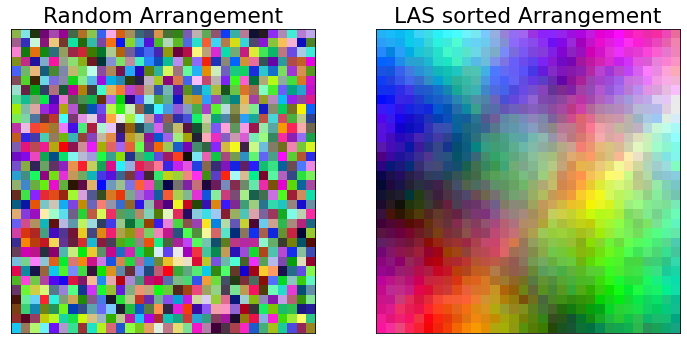

In [13]:
sorted_X = sort_with_las(X.copy(), radius_factor=0.85, wrap=False)
plot_grid(X, sorted_X, figsize=6, titles=["Random Arrangement", "LAS sorted Arrangement"])

Sorted with FLAS in 3.030 seconds


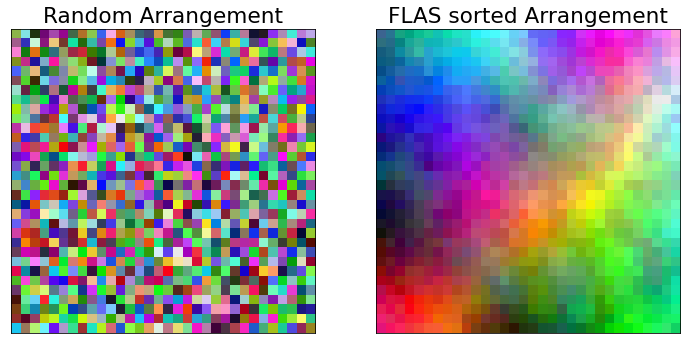

In [14]:
sorted_X = sort_with_flas(X.copy(), nc=49, radius_factor=0.88, wrap=False)
plot_grid(X, sorted_X, figsize=6, titles=["Random Arrangement", "FLAS sorted Arrangement"])

### Sort 10000 colors

Sorted with FLAS in 11.490 seconds


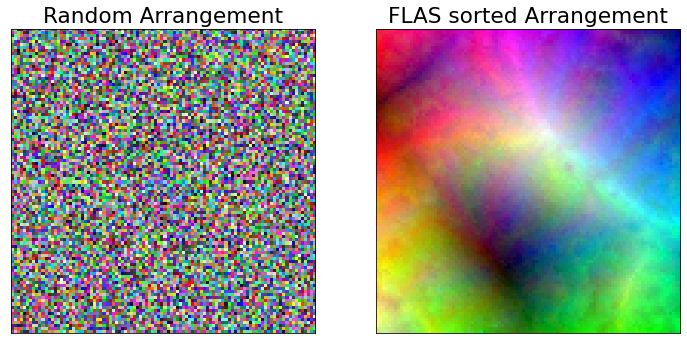

In [15]:
X = generate_random_colors(100, 100)
sorted_X = sort_with_flas(X.copy(), nc=81, radius_factor=0.8, wrap=False)
plot_grid(X, sorted_X, figsize=6, titles=["Random Arrangement", "FLAS sorted Arrangement"])

Sorted with FLAS in 10.672 seconds


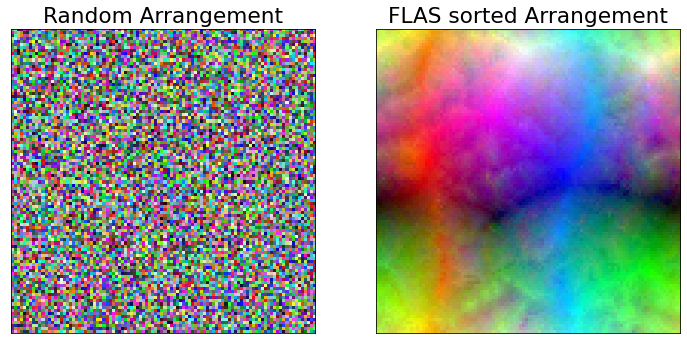

In [16]:
X = generate_random_colors(100, 100)
sorted_X = sort_with_flas(X.copy(), nc=81, radius_factor=0.8, wrap=True)
plot_grid(X, sorted_X, figsize=6, titles=["Random Arrangement", "FLAS sorted Arrangement"])

## Distance Preservation Quality (DPQ)

In [17]:
''' Converts a given gridshape to a grid index matrix
    and calculates the squared spatial distances'''
def compute_spatial_distances_for_grid(grid_shape, wrap):
    if wrap:
        return compute_spatial_distances_for_grid_wrapped(grid_shape)
    else:
        return compute_spatial_distances_for_grid_non_wrapped(grid_shape)

In [18]:
def compute_spatial_distances_for_grid_wrapped(grid_shape):
    
    n_x = grid_shape[0]
    n_y = grid_shape[1]

    wrap1 = [[0,   0], [0,   0], [0,     0], [0, n_y], [0,   n_y], [n_x, 0], [n_x,   0], [n_x, n_y]]
    wrap2 = [[0, n_y], [n_x, 0], [n_x, n_y], [0,   0], [n_x,   0], [  0, 0], [  0, n_y], [  0,   0]]
    
    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = np.indices(grid_shape)
    mat = np.concatenate([np.expand_dims(a, -1), np.expand_dims(b, -1)], axis=-1)
    mat_flat = mat.reshape((-1, 2))
    
    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    for i in range(8):
        # look for smaller distances with wrapped coordinates
        d_i = squared_l2_distance(mat_flat + wrap1[i], mat_flat + wrap2[i])
        d = np.minimum(d, d_i)
        
    return d

In [19]:
def compute_spatial_distances_for_grid_non_wrapped(grid_shape):
    
    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = np.indices(grid_shape)
    mat = np.concatenate([np.expand_dims(a, -1), np.expand_dims(b, -1)], axis=-1)
    mat_flat = mat.reshape((-1, 2))
    
    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    return d

In [20]:
''' comparator for custom sort with two types of distances '''
def key_fn(a,b):

    if a[1] < b[1]:
        return -1
    elif a[1] > b[1]:
        return 1
    else:
        if a[0] < b[0]:
            return -1
        elif a[0] > b[0]:
            return 1
        else:
            return 0
        
''' sort a single row so that values are sorted by the 
    spatial distance and in case they are equal, by the HD distance '''
def sort_row(hd, sd): 

    # combine the two rows of spatial and HD distances to a single list of tuples (hd_i, sd_i)
    zipped_list = list(zip(hd, sd))
    # sort the list of tuples
    sorted_zipped = sorted(zipped_list, key=cmp_to_key(key_fn))

    # unzip the list of tuples and return the sorted HD distances of the current row
    sorted_HD_distances, _ = list(zip(*sorted_zipped))
    return np.array(sorted_HD_distances)

In [21]:
''' sorts a matrix so that row values are sorted by the 
    spatial distance and in case they are equal, by the HD distance '''
def sort_hddists_by_2d_dists(hd_dists, spatial_dists):
    
    # create empty 2D array
    sorted_HD_D = np.zeros_like(hd_dists)
    
    # sort each row of the two matrices and fill empty 2D array with sorted values
    for i in range(len(hd_dists)):
        
        sorted_row = sort_row(hd_dists[i], spatial_dists[i])
        sorted_HD_D[i] = sorted_row
        
    return sorted_HD_D

In [22]:
''' computes the Distance Preservation Gain delta DP_k(S) '''
def get_distance_preservation_gain(sorted_d_mat, d_mean):
    
    # range of numbers [1, K], with K = N-1
    nums = np.arange(1, len(sorted_d_mat))
    
    # compute cumulative sum of neighbor distance values for all rows, shape = (N, K)
    cumsum = np.cumsum(sorted_d_mat[:, 1:], axis=1)
    
    # compute average of neighbor distance values for all rows, shape = (N, K)
    d_k = (cumsum / nums)
    
    # compute average of all rows for each k, shape = (K, )
    d_k = d_k.mean(axis=0)
    
    # compute Distance Preservation Gain and set negative values to 0, shape = (K, )
    d_k = np.clip((d_mean - d_k) / d_mean, 0, np.inf)
   
    return d_k 

In [23]:
''' computes the Distance Preservation Quality DPQ_p(S)'''
def distance_preservation_quality(sorted_X, p=2, wrap=False):
    
    # setup of required variables
    grid_shape = sorted_X.shape[:-1]
    N = np.prod(grid_shape)
    H, W = grid_shape
    flat_X = sorted_X.reshape((N, -1))
    
    # compute matrix of euclidean distances in the high dimensional space
    dists_HD = np.sqrt(squared_l2_distance(flat_X, flat_X)) 
    
    # sort HD distance matrix rows in acsending order (first value is always 0 zero now)
    sorted_D = np.sort(dists_HD, axis=1)
    
    # compute the expected value of the HD distance matrix
    mean_D = sorted_D[:, 1:].mean()
    
    # compute spatial distance matrix for each position on the 2D grid
    dists_spatial = compute_spatial_distances_for_grid(grid_shape, wrap)
    
    # sort rows of HD distances by the values of spatial distances
    sorted_HD_by_2D = sort_hddists_by_2d_dists(dists_HD, dists_spatial)
    
    # get delta DP_k values
    delta_DP_k_2D = get_distance_preservation_gain(sorted_HD_by_2D, mean_D)
    delta_DP_k_HD = get_distance_preservation_gain(sorted_D, mean_D)
     
    # compute p norm of DP_k values
    normed_delta_D_2D_k = np.linalg.norm(delta_DP_k_2D, ord=p)
    normed_delta_D_HD_k = np.linalg.norm(delta_DP_k_HD, ord=p)
    
    # DPQ(s) is the ratio between the two normed DP_k values
    DPQ = normed_delta_D_2D_k/normed_delta_D_HD_k
   
    return DPQ

## Lets test the DPQ

In [24]:
# lets create a 2D color gradient
size = 20
gradient_image = np.zeros((size, size, 3))
for y in range(size):
    for x in range(size):
        
        r = 1.*x/(size-1)
        g = 0
        b = 1.*y/(size-1)
        
        gradient_image[y,x] = np.array([r,g,b])

gradient_image = gradient_image.astype(float)

# and compute DPQ values for our randomly generated RGB image
random_image = generate_random_colors(size, size)
random_image_dpq = distance_preservation_quality(random_image)

# and the color gradient image
gradient_image_dpq = distance_preservation_quality(gradient_image)

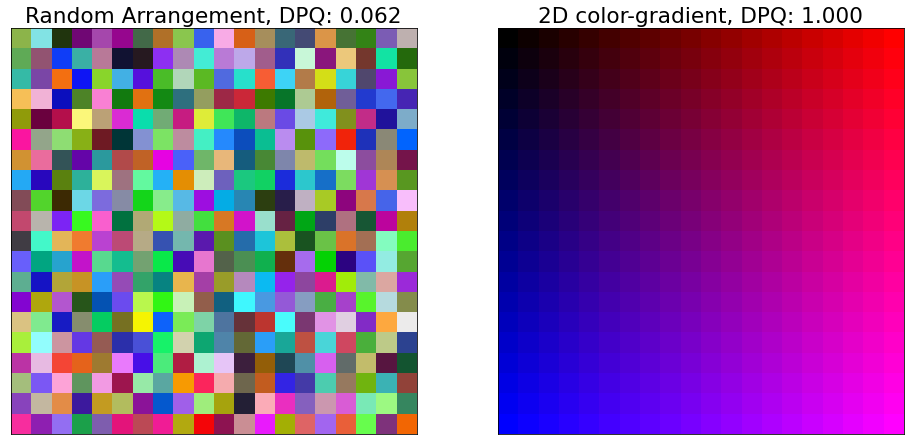

In [25]:
plot_grid(random_image, gradient_image, figsize=8, titles=[f"Random Arrangement, DPQ: {random_image_dpq:0.3f}", f"2D color-gradient, DPQ: {gradient_image_dpq:0.3f}"])

## Now lets experiment with different FLAS parameters for unwrapped grids

.. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. 

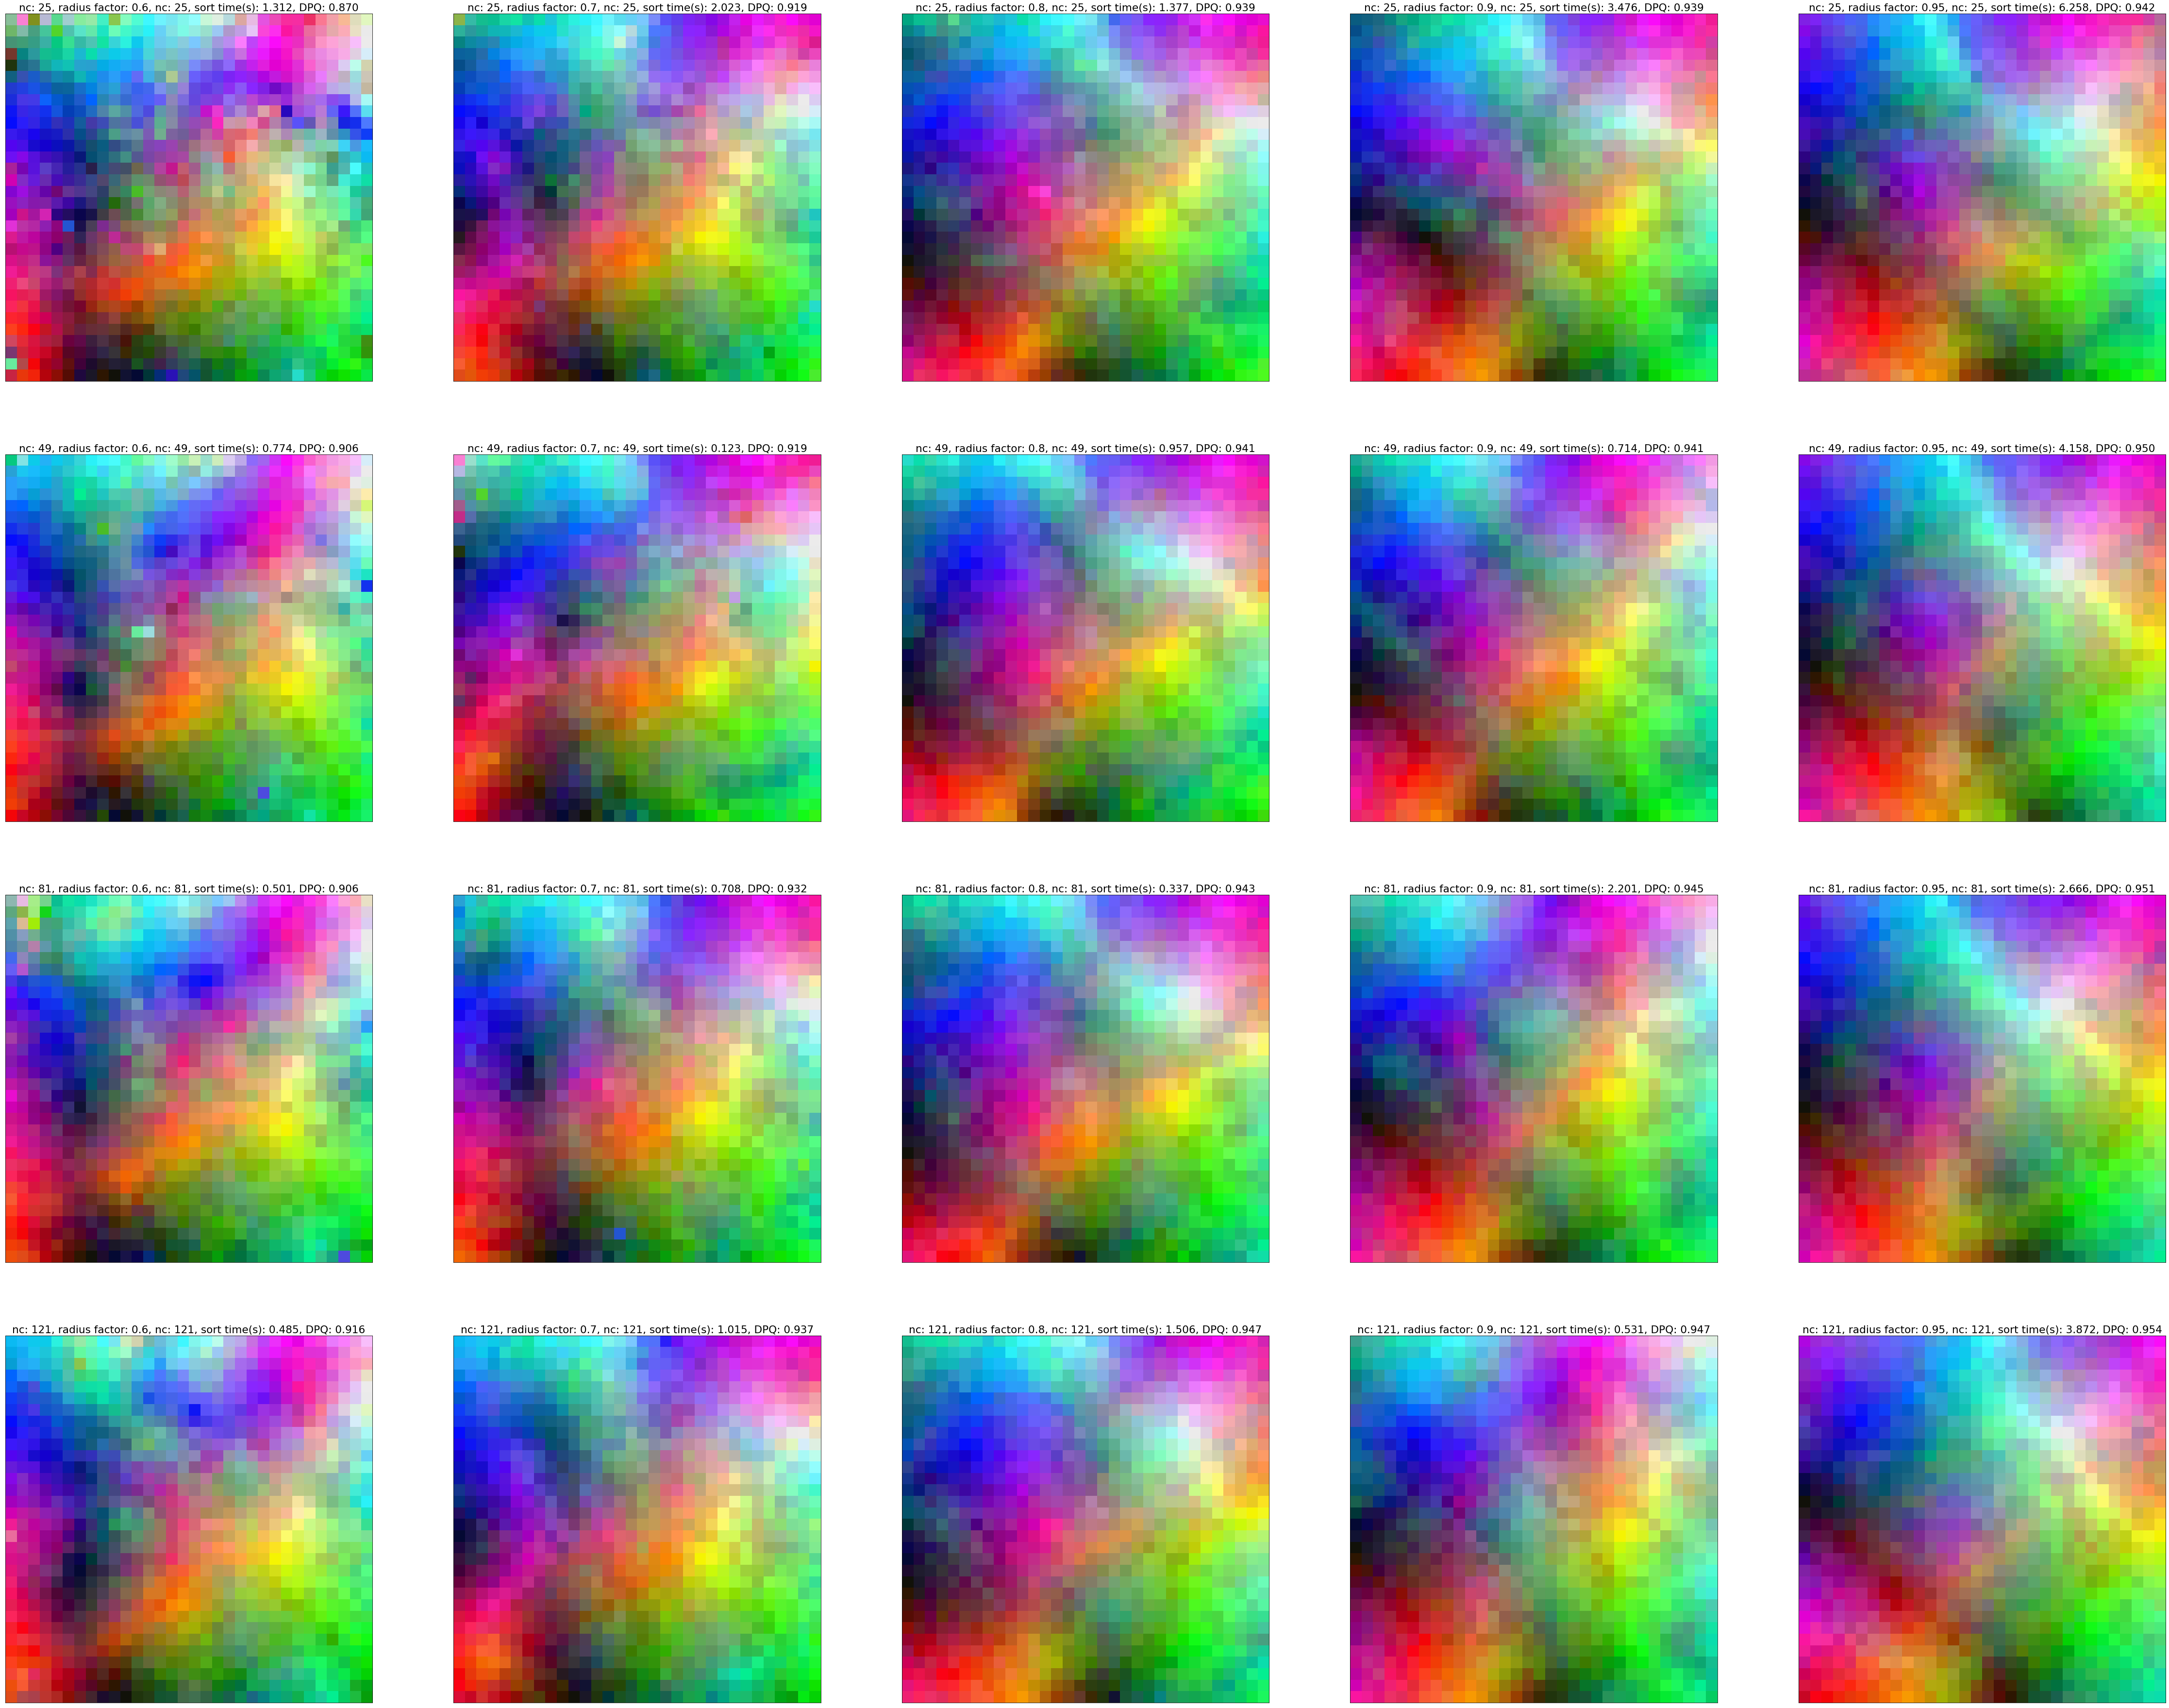

In [26]:
images = []
titles = []

size = 32
X = generate_random_colors(size, size)

for nc in [25, 49, 81, 121]:
    for rf in [0.6, 0.7, 0.8, 0.9, 0.95]:
        print(".", end="")
        # sort random image with current FLAS parameters
        sorted_X, duration = sort_with_flas(X.copy(), radius_factor=rf, nc=nc, return_time=True)
        
        # store sorted image
        images.append(sorted_X)
        
        # get DPQ(S)
        dpq = distance_preservation_quality(sorted_X, p=16)
        print(". ", end="")
        
        # create string with parameters, duration and DPQ
        titles.append(f"nc: {nc}, radius factor: {rf}, nc: {nc}, sort time(s): {duration:0.3f}, DPQ: {dpq:0.3f}")

# plot the results
plot_grid(*images, figsize=16, titles=titles)

## And now for wrapped grids

.. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. 

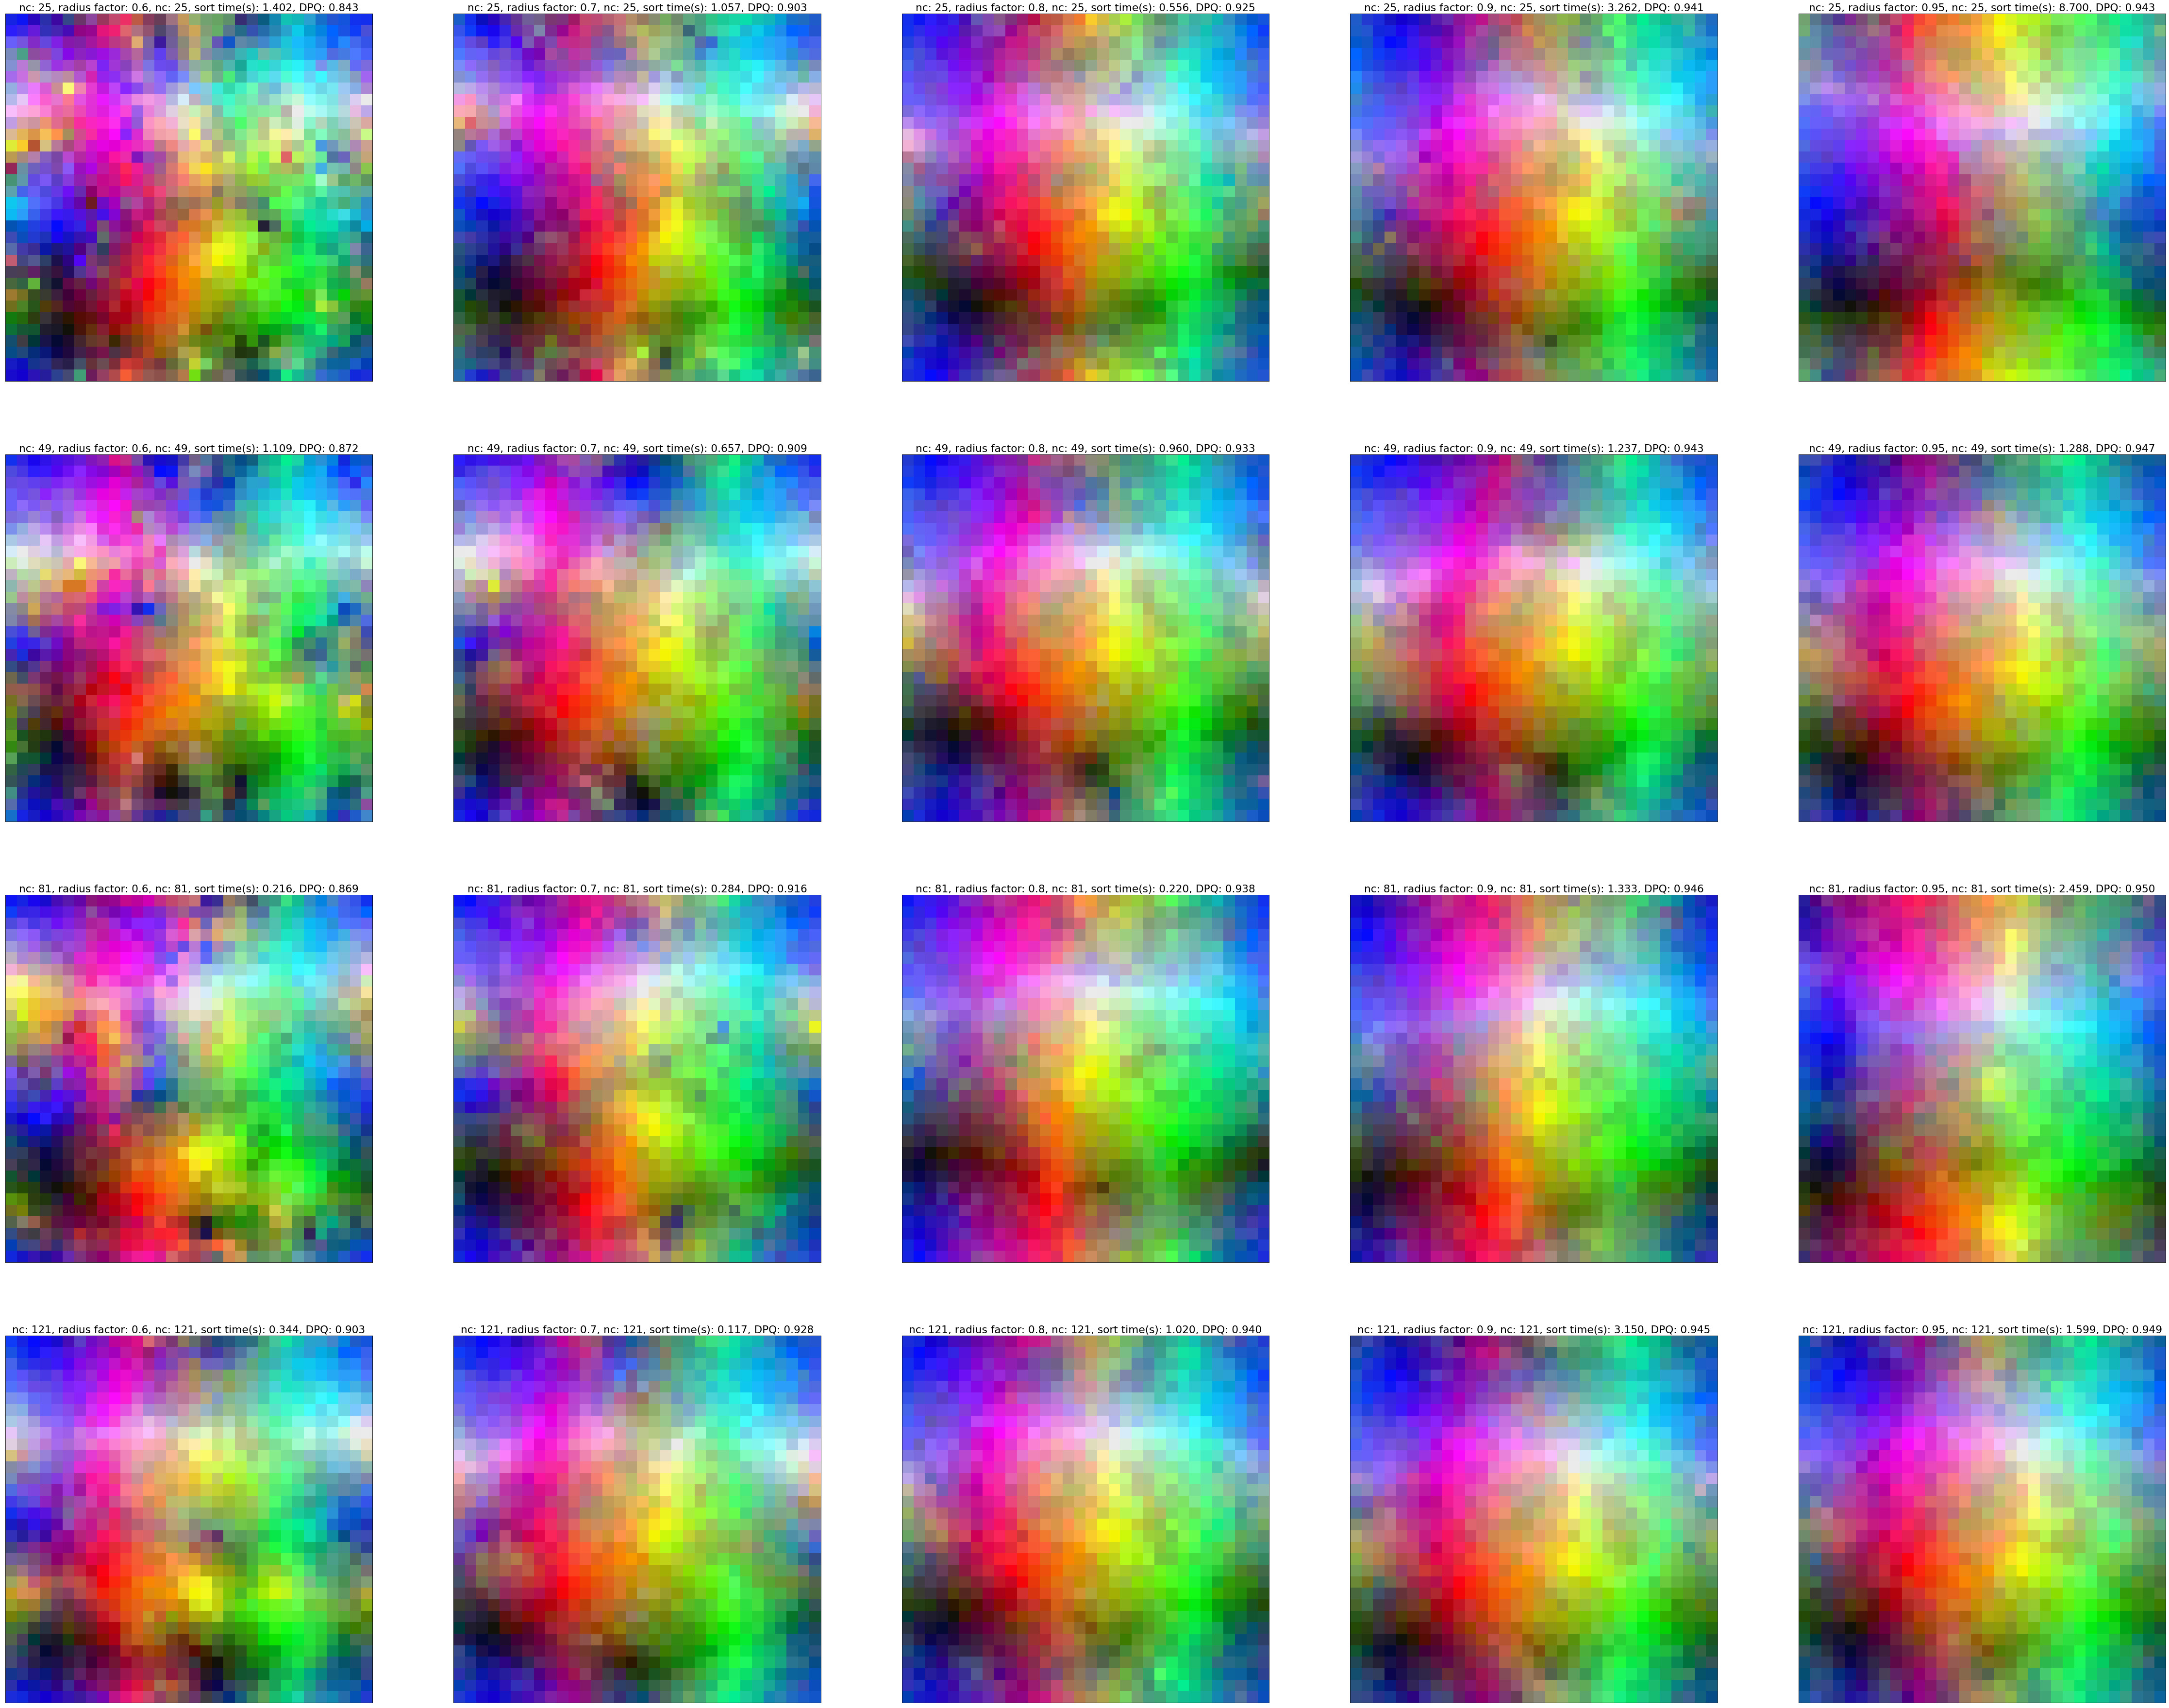

In [27]:
images = []
titles = []

size = 32
X = generate_random_colors(size, size)

for nc in [25, 49, 81, 121]:
    for rf in [0.6, 0.7, 0.8, 0.9, 0.95]:
        print(".", end="")
        # sort random image with current FLAS parameters
        sorted_X, duration = sort_with_flas(X.copy(), radius_factor=rf, nc=nc, return_time=True, wrap=True)
        
        # store sorted image
        images.append(sorted_X)
        
        # get DPQ_p(S)
        dpq = distance_preservation_quality(sorted_X, p=16, wrap=True)
        print(". ", end="")
        
        # create string with parameters, duration and DPQ
        titles.append(f"nc: {nc}, radius factor: {rf}, nc: {nc}, sort time(s): {duration:0.3f}, DPQ: {dpq:0.3f}")

# plot the results
plot_grid(*images, figsize=16, titles=titles)